### Feature Importance
- normalized feature importance score by themselves

In [1]:
# general:
import pandas as pd
import numpy as np
# self-written functions:
import sys
sys.path.append("../data_process/")
sys.path.append("../modeling/")
import ML_func as ml
import data_cleaner as dc

In [3]:
# data:
test = dc.load_py('../../clean_data/test.pkl')   # CatBoost & light GBM use categorical
train = dc.load_py('../../clean_data/train.pkl')
x_test_dummy = dc.load_py('../../clean_data/test_dummy.pkl')    # XGBoost use one-hot encoding
x_train_dummy = dc.load_py('../../clean_data/train_dummy.pkl')
x_test_dummy.pop('progress')   
x_train_dummy.pop('progress')
x_test = test.copy()
x_train = train.copy()
y_test = x_test.pop('progress')
y_train = x_train.pop('progress')
cat_features=['PTGENDER', 'PTETHCAT', 'PTMARRY', 'PTRACCAT']
# models:
c = dc.load_py('../modeling/models/CatBoost_optimal.pkl')
l = dc.load_py('../modeling/models/LightGBM_optimal.pkl')
x = dc.load_py('../modeling/models/XGBoost_optimal.pkl')
rf = dc.load_py('../modeling/models/baseline5.pkl')
rf = rf["Random Forest"]

In [4]:
top_n = 20
fi={
    'XGBoost':pd.Series(x.feature_importances_/sum(x.feature_importances_)*100,
                         index=x_train_dummy.columns) \
                        .sort_values(ascending=False)[:top_n][::-1],
    'CatBoost':pd.Series(c.feature_importances_/sum(c.feature_importances_)*100,
                         index=x_train.columns)\
                        .sort_values(ascending=False)[:top_n][::-1],
    'LightGBM':pd.Series(l.feature_importances_/sum(l.feature_importances_)*100,  
                        index=x_train.columns) \
                        .sort_values(ascending=False)[:top_n][::-1],
    'Random Forest':pd.Series(rf.feature_importances_/sum(rf.feature_importances_)*100,
                        index=x_train_dummy.columns) \
                        .sort_values(ascending=False)[:top_n][::-1],
    
}
df_fi = pd.DataFrame(fi).fillna(0)  # fill importance not in top n to 0

In [5]:
# calculate the cosine similarity of top n features
from numpy import dot
from numpy.linalg import norm
from itertools import combinations
for m1,m2 in combinations(df_fi.columns.tolist(),2):
    a = df_fi[m1]
    b = df_fi[m2]
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    print(f"Cosine similarity of the top {top_n} features in {m1} & {m2}: {cos_sim}")

Cosine similarity of the top 20 features in XGBoost & CatBoost: 0.743151912930855
Cosine similarity of the top 20 features in XGBoost & LightGBM: 0.5957624286467399
Cosine similarity of the top 20 features in XGBoost & Random Forest: 0.688447173879398
Cosine similarity of the top 20 features in CatBoost & LightGBM: 0.7108909482118778
Cosine similarity of the top 20 features in CatBoost & Random Forest: 0.891094067920436
Cosine similarity of the top 20 features in LightGBM & Random Forest: 0.6707864148606232


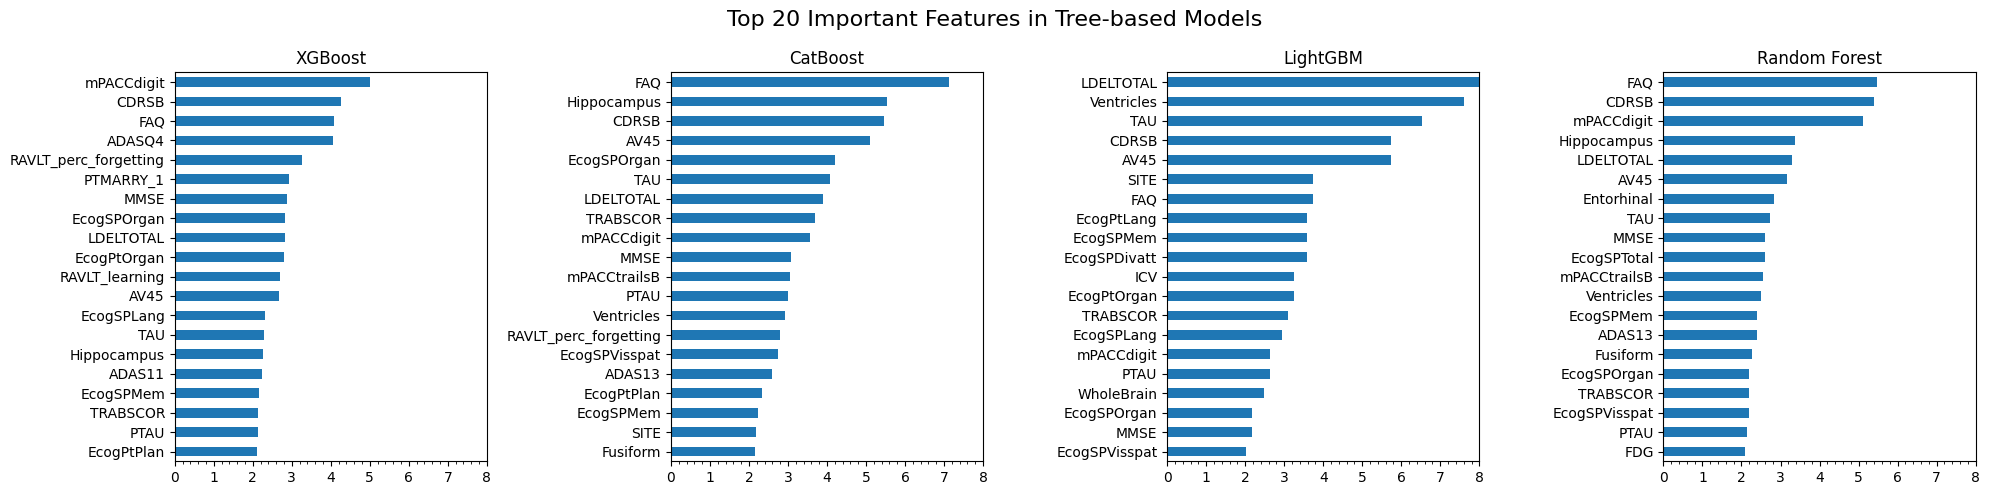

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
upper_bound = 8  # upper bound for importance value
fig, axes = plt.subplots(nrows=1, ncols=len(fi), figsize=(5*len(fi), 5))
fig.suptitle('Top ' + str(top_n) + ' Important Features in Tree-based Models', fontsize=16)
# Loop over the feature importance data and plot each series as a horizontal bar plot
for i, (model_name, data) in enumerate(fi.items()):
    data[:top_n][::-1].plot(kind='barh', ax=axes[i])
    axes[i].set_title(model_name)
    axes[i].invert_yaxis()
    axes[i].set_xlim([0, upper_bound])
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axes[i].xaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.tight_layout()
# plt.show()
plt.savefig('../output/feature_importance.svg', dpi=300)